# Using graph retrieval to get bioregistry coverage in KGs
In this tutorial we will be showing how to use the [GRAPE](https://github.com/AnacletoLAB/grape)'s graph retrieval tooling to quickly check the [bioregistry](https://github.com/biopragmatics/bioregistry) support for the CURIE's within the graph.

## What is Bioregistry
The standardized identification of biomedical entities is a cornerstone of interoperability, reuse, and data integration in the life sciences. Several registries have been developed to catalog resources maintaining identifiers for biomedical entities such as small molecules, proteins, cell lines, and clinical trials. However, existing registries have struggled to provide sufficient coverage and metadata standards that meet the evolving needs of modern life sciences researchers. Here, we introduce the Bioregistry, an integrative, open, community-driven metaregistry that synthesizes and substantially expands upon 20 existing registries. The Bioregistry addresses the need for a sustainable registry by leveraging public infrastructure and automation, and employing a progressive governance model centered around open code and open data to foster community contribution. The Bioregistry can be used to support the standardized annotation of data, models, ontologies, and scientific literature, thereby promoting their interoperability and reuse.

## Installing the libraries
You can install GRAPE and bioregistry, plus the necessary libraries, by running:

```bash
pip install grape barplots -U
```

## Versions of the software used within this Jupyter Notebook

In [10]:
from grape.__version__ import __version__
from bioregistry import version

In [11]:
"GRAPE version: ", __version__

('GRAPE version: ', '0.1.20')

In [15]:
version.get_version(with_git_hash=True)

'0.5.68-dev-None'

## Getting the datasets
First of all, we get the methods to get the available graphs from a repository and the method to load a graph by name.

In [1]:
from grape.datasets import (
    get_available_graphs_from_repository,
    get_dataset,
    get_available_versions_from_graph_and_repository
)

## Getting the normalization tools
Then, we load the bioregistry APIs to normalize a given curie:

In [2]:
from bioregistry import normalize_curie, curie_from_iri

## Some additional tooling
Finally, we load some additional tooling to make everything a bit more understandable, faster and look nicer:

In [3]:
from typing import Dict, Tuple, Any
from tqdm.auto import tqdm
import pandas as pd
from multiprocessing import Pool, cpu_count
from barplots import barplots

## The normalization code
Now, for each graph we want to:

* Get the node names that are not currently being mapped
* Know how many are mapped
* Get a good looking plot displaying these informations

In [4]:
def normalization_attempt(
    graph_name_and_repository: Tuple[str, str]
) -> Dict[str, Any]:
    """Return triple with the graph name, repository and list of nodes that fail parsing.
    
    Parameters
    -----------------
    graph_name_and_repository: Tuple[str, str]
        Tuple with name of the graph and repository.
        
    Returns
    -----------------
    Triple with:
        - Name of the graph
        - Name of the repository
        - List of node names and their degree that fail parsing
    """
    graph_name, repository = graph_name_and_repository
    version = sorted(get_available_versions_from_graph_and_repository(
        graph_name=graph_name,
        repository=repository
    ))[-1]
    graph = get_dataset(
        graph_name=graph_name,
        repository=repository,
        version=version
    )()
    node_names_and_degrees = [
        (node_name, node_degree)
        for node_name, node_degree in zip(
            graph.get_node_names(),
            graph.get_node_degrees()
        )
        if curie_from_iri(node_name) is None and normalize_curie(node_name) is None
    ]
    return dict(
        graph_name=graph_name,
        version=version,
        repository=repository,
        number_of_nodes=graph.get_number_of_nodes(),
        number_of_supported_nodes=graph.get_number_of_nodes() - len(node_names_and_degrees),
        bioregistry_coverage_rate=(
            (graph.get_number_of_nodes() - len(node_names_and_degrees)) / graph.get_number_of_nodes()
        ),
        node_names_and_degrees=node_names_and_degrees
    )

Then we define the set of tasks to execute:

In [5]:
# The EPSO graph has been recently renamed in OBO,
# but still appears in the metadata.
deny_list = ["EPSO"]

tasks = [
    (graph_name, repository)
    for repository in ("kgobo", "kghub", "monarchinitiative", "pheknowlatorkg")
    for graph_name in get_available_graphs_from_repository(repository)
    if graph_name not in deny_list
]

And finally, we actually run the normalization procedure:

In [6]:
%%time
with Pool(cpu_count()) as p:
    non_normalized = pd.DataFrame([
        dict(
            **data,
            node_name=node_name,
            node_degree=node_degree
        )
        for data in tqdm(
            p.imap(normalization_attempt, tasks),
            total=len(tasks),
            desc="Parsing graphs"
        )
        for (node_name, node_degree) in data.pop("node_names_and_degrees")
    ])
    p.close()
    p.join()

Parsing graphs:   0%|          | 0/204 [00:00<?, ?it/s]

CPU times: user 4.37 s, sys: 595 ms, total: 4.96 s
Wall time: 10min 57s


Let's take a look at the results!

In [7]:
non_normalized

,graph_name,version,repository,number_of_nodes,number_of_supported_nodes,bioregistry_coverage_rate,node_name,node_degree
0,FBBT,2022-08-11,kgobo,19797,19748,0.997525,http://ontologydesignpatterns.org/wiki/Communi...,1
1,FBBT,2022-08-11,kgobo,19797,19748,0.997525,http://ontologydesignpatterns.org/wiki/Submiss...,1
2,FBBT,2022-08-11,kgobo,19797,19748,0.997525,http://ontologydesignpatterns.org/wiki/Submiss...,1
3,FBBT,2022-08-11,kgobo,19797,19748,0.997525,http://wiki.geneontology.org/index.php/Acts_up...,1
4,FBBT,2022-08-11,kgobo,19797,19748,0.997525,http://wiki.geneontology.org/index.php/Acts_up...,1
...,...,...,...,...,...,...,...,...
1379579,PheKnowLator,v3.0.2-2021-10-18.subclass-relationsOnly-owlne...,pheknowlatorkg,780375,589258,0.755096,https://uswest.ensembl.org/Homo_sapiens/Transc...,3
1379580,PheKnowLator,v3.0.2-2021-10-18.subclass-relationsOnly-owlne...,pheknowlatorkg,780375,589258,0.755096,https://uswest.ensembl.org/Homo_sapiens/Transc...,3
1379581,PheKnowLator,v3.0.2-2021-10-18.subclass-relationsOnly-owlne...,pheknowlatorkg,780375,589258,0.755096,https://uswest.ensembl.org/Homo_sapiens/Transc...,3
1379582,PheKnowLator,v3.0.2-2021-10-18.subclass-relationsOnly-owlne...,pheknowlatorkg,780375,589258,0.755096,https://uswest.ensembl.org/Homo_sapiens/Transc...,3


## Coverage visualizations
We visualize the coverage rates for most graphs (for the OBO graphs we limit ourselves to the least covered ones for space reasons) using a bar plot:

[(<Figure size 1000x1320 with 1 Axes>,
  array([<AxesSubplot:title={'center':'Bioregistry coverage rate'}, xlabel='Bioregistry coverage rate'>],
        dtype=object))]

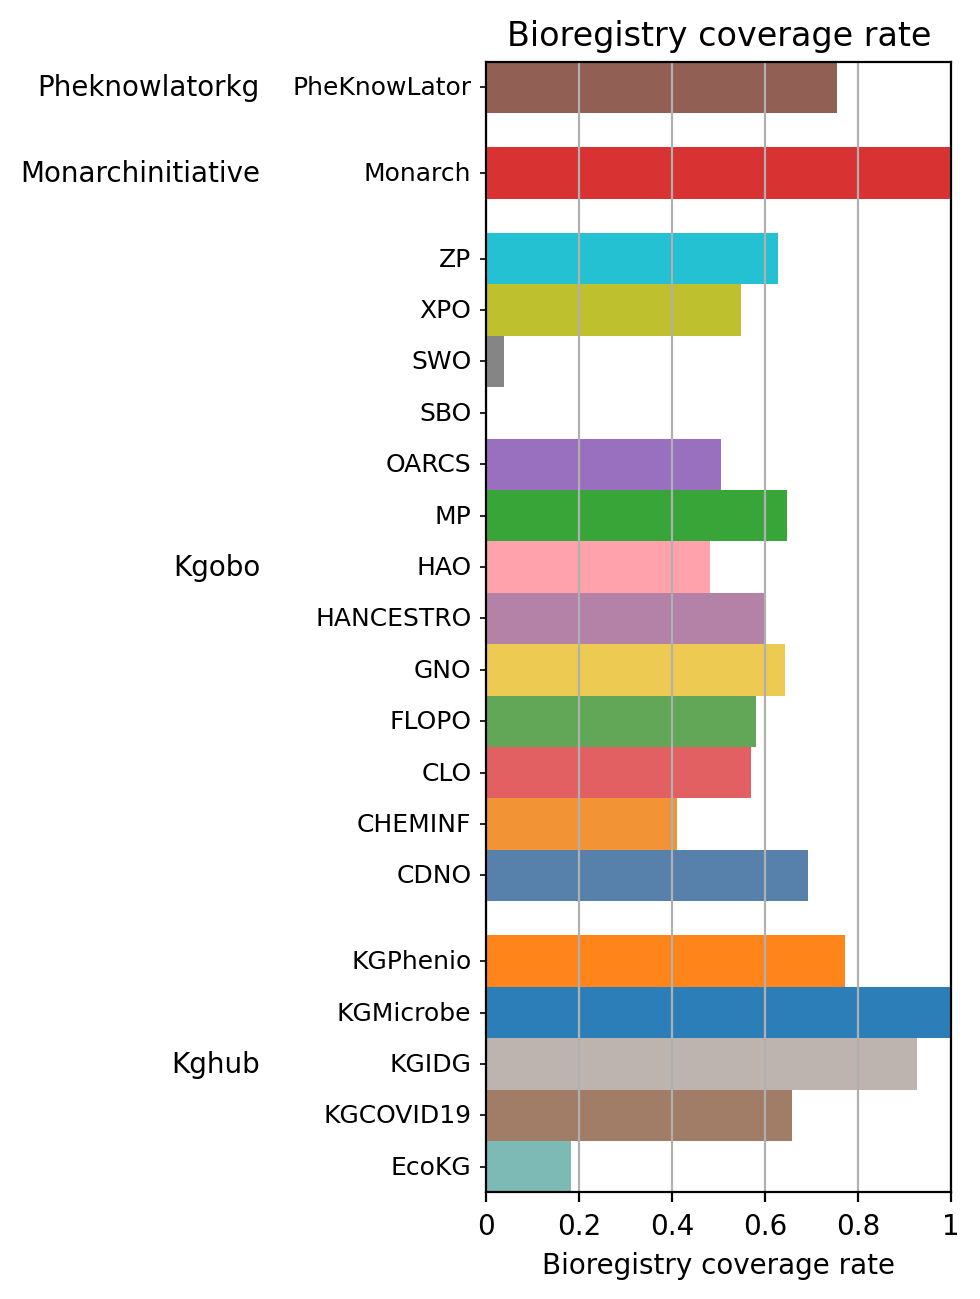

In [8]:
barplots(
    non_normalized[
        (non_normalized.repository!="kgobo") |
        (non_normalized.bioregistry_coverage_rate < 0.7)
    ][["repository", "graph_name", "bioregistry_coverage_rate"]],
    groupby=["repository", "graph_name"],
    height=5,
    max_value=1.0,
    minor_rotation=0,
    show_last_level_as_legend=False,
    orientation="horizontal"
)

## Storing the results to file
To store the results we simply save it as a compressed TSV document:

In [9]:
non_normalized.to_csv("non_normalized.tsv.gz", sep="\t", index=False)